In [275]:
import os
import csv
import numpy as np
import random
import tensorly as tl
from tensorly.decomposition import non_negative_parafac
import scipy.sparse
import sys
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [276]:
def Qmat(S,configuration,path):
    dirname = os.fsdecode(configuration)
    filename = os.path.join(path, dirname+'/coords.csv_sparse_graph.npz')
    if os.path.isfile(filename): 
        A = scipy.sparse.load_npz(filename)
        '''construct modularity matrix'''
        M = A
        k = A.sum(axis=0)
        w = A.sum(axis=None)
        M = A - np.outer(k,k)*0.5/w
        Q = M.shape[0]*M.shape[1]*np.trace(np.dot(np.dot(S.transpose(),M),S))/(2.0*w) #rescale by network size
    return Q

def sample_modularity(S,cf_samples,path):
    modularity_values = []
    for configuration in cf_samples:
            modularity_values.append(Qmat(S,configuration,path))  
    return modularity_values

def random_community(Sp,configuration,path):
    np.random.shuffle(Sp)
    return Qmat(Sp,configuration,path)

def membership(factors):
    S = np.zeros(shape=factors[1][1].shape)
    for c in range(comm):
        vec = 0.5*(factors[1][1][:,c]+factors[1][2][:,c]) # take the average of the 2 factors, that should be identical
        S[:,c] = vec/tl.norm(vec,1) #normalize membership
    Sp = np.copy(S) # this copy can be used for significance testing
    return S,Sp

In [217]:
samples = 20 #numb of sampled 3d structured
path = '/media/garner1/hdd1/gpseq/10000'
configurations = os.listdir(path) 
config_sample = random.sample(configurations, k=samples) # sample k times without replacement from configurations

In [226]:
rank = 3 # numb of components in svd. The greater this value the slower the parafac convergence 
comm = 10 # numb of communities to retrive

In [227]:
T = np.zeros(shape = (samples, 3043, 3043), dtype = np.float32)
graph_idx = 0
for config in config_sample:
    dirname = os.fsdecode(config)
    filename = os.path.join(path, dirname+'/coords.csv_tsvd.npz')
    if os.path.isfile(filename): 
        svd = np.load(filename)
        u = svd['u'][:,:rank]
        s = svd['s'][:rank]
        vt = svd['vt'][:rank,:]
        T[graph_idx,:,:] = np.dot(np.dot(u,np.diag(s)),vt)
        del svd
        continue
    else:
        T[graph_idx,:,:] = np.zeros(shape = (3043,3043),)
        continue
    graph_idx += 1

print(T.shape)   
factors = non_negative_parafac(T, rank=comm, verbose=1, n_iter_max=20,tol=1e-08,init='svd')
[factors[1][ind].shape for ind in range(3)]

(20, 3043, 3043)
reconstruction error=0.8126384171188588
reconstruction error=0.8123308653401632, variation=0.0003075517786955695.
reconstruction error=0.7291736137779663, variation=0.08315725156219689.
reconstruction error=0.6483471686864567, variation=0.0808264450915096.
reconstruction error=0.5530094518622528, variation=0.09533771682420389.
reconstruction error=0.48614578809573444, variation=0.06686366376651837.
reconstruction error=0.4438520569222931, variation=0.04229373117344132.
reconstruction error=0.41805678657836565, variation=0.02579527034392748.
reconstruction error=0.4012232358913235, variation=0.01683355068704212.
reconstruction error=0.3886839890810624, variation=0.01253924681026114.
reconstruction error=0.37880312170179914, variation=0.009880867379263247.
reconstruction error=0.3707212992769867, variation=0.008081822424812424.
reconstruction error=0.3639665066034362, variation=0.006754792673550503.
reconstruction error=0.3585055531678382, variation=0.005460953435597993.

[(20, 10), (3043, 10), (3043, 10)]

In [228]:
S, Sp = membership(factors)

In [229]:
h1 = sample_modularity(S,config_sample) # S on the training data

In [230]:
h2 = sample_modularity(S,random.sample(os.listdir(path), k=100)) # S on the test data

In [231]:
ind = 1
h3 = [random_community(Sp,config_sample[ind]) for count in range(100)] # random S on one of the training data
mu = np.mean(h3); sigma = np.std(h3)

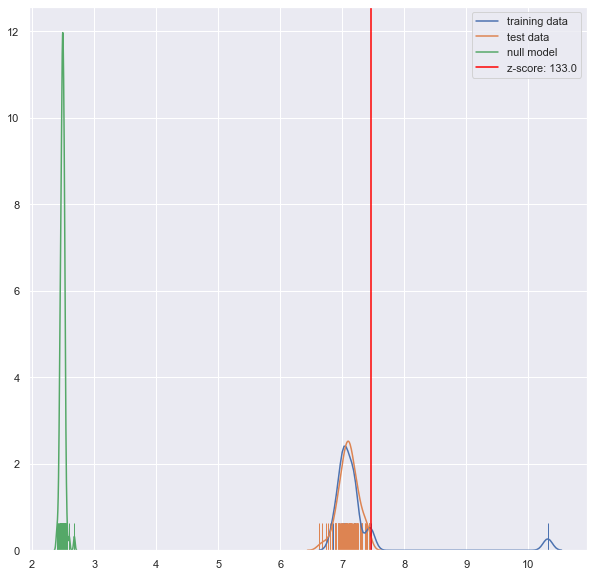

In [273]:
sns.set(rc={'figure.figsize':(10,10)})
labels = ['training data','test data', 'null model']
histos = [h1,h2,h3]
fig, ax = plt.subplots()
for count in range(3):
#     sns.distplot(histos[count], kde=False,norm_hist=True,label=labels[count],hist_kws=dict(alpha=0.7))
    sns.distplot(histos[count], rug=True, hist=False,label=labels[count])
    

ref = Qmat(S,config_sample[ind])
ax.axvline(ref,color='red',label='z-score: '+str(np.round((ref-mu)/sigma))) # draw a red vertical line at the value of S for the example graph
plt.legend()
# print('z-score is: '+str((ref-mu)/sigma))  # z-score for a random S as the null model

In [ ]:
for i in range(comm):
    a = factors[1][1][:,i]
    b = factors[1][2][:,i]
    c = factors[1][0][:,i]
    mat = np.outer(0.5*(a+b),0.5*(a+b)) # symmetrize wrt a & b
    print(tl.norm(a,2)*tl.norm(b,2)*tl.norm(c,2))
#     plt.imshow(mat, cmap='Blues', interpolation='nearest')
    plt.figure(figsize=(10, 10))
    sns.heatmap(mat,cmap='Blues',square=True,xticklabels=False,yticklabels=False)
    plt.show()  
      

In [ ]:
ind = 3
dirname = os.fsdecode(config_sample[ind])
filename = os.path.join(path, dirname+'/coords.csv_sparse_graph.npz')
A = scipy.sparse.load_npz(filename).todense()
sns.heatmap(A,cmap='Blues',square=True,xticklabels=False,yticklabels=False)

In [ ]:
for i in range(comm):
    mat = np.outer(S[:,i],S[:,i]) # symmetrize wrt a & b
    plt.figure(figsize=(10, 10))
    sns.heatmap(np.round(mat.shape[0]*mat.shape[1]*np.multiply(mat,A),decimals=3),square=True,xticklabels=False,yticklabels=False)
    plt.show()  